In [53]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals
import networkx as nx

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# 7章 ロジスティクスネットワークの最適設計を行う10本ノック

ここでは、最適化計算を行ういくつかのライブラリを用いて、最適化計算を実際に行う。  
そして、6章で用いたネットワーク可視化などの技術を駆使し、計算結果の妥当性を確認する方法についても学ぶ。

- ロジスティクス・ネットワーク（物流ネットワーク）
  - 最終的に製品を販売する小売店（商店P, Q）がある
  - 小売店で販売される製品群（製品A, B）には、一定の需要がある
  - 各需要量に基づいて工場（工場X, Y）での生産量は決められる
  - それぞれの製品をどの工場のどのライン（レーン0, 1）で製造するかについては、
    - 各工場から小売店への輸送費、製造コストなどを加味して決められる

### Knock61: 輸送最適化問題を解く

In [54]:
# データ読み込み

df_tc = pd.read_csv("../support/7章/trans_cost.csv", index_col="工場")
df_demand = pd.read_csv("../support/7章/demand.csv")
df_supply = pd.read_csv("../support/7章/supply.csv")

display(df_tc)
display(df_demand)
display(df_supply)

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [55]:
# 初期設定

np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))
print(range(nw))
print(range(nf))
print(pr)

range(0, 3)
range(0, 4)
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [56]:
# 数理モデルの作成

# 「最小化を行う」モデルを定義
m1 = model_min()

# 工場と倉庫の組み合わせの変数
v1 = {
    (i, j): LpVariable("v%d_%d"%(i, j), lowBound=0) for i, j in pr
}
"""
v1
{
    (0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, 
    (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, 
    (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3
}
"""

# 目的関数の定式化
m1 += lpSum(df_tc.iloc[i][j] * v1[i, j] for i, j in pr)
"""
m1
NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous
"""

'\nm1\nNoName:\nMINIMIZE\n10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0\nVARIABLES\nv0_0 Continuous\nv0_1 Continuous\nv0_2 Continuous\nv0_3 Continuous\nv1_0 Continuous\nv1_1 Continuous\nv1_2 Continuous\nv1_3 Continuous\nv2_0 Continuous\nv2_1 Continuous\nv2_2 Continuous\nv2_3 Continuous\n'

In [57]:
# 工場の制約条件
# 工場の製造する製品が需要を満たすようにする
for i in range(nw):
    m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]

# 倉庫の制約条件
# 倉庫の供給する部品が供給限界を超過しないようにする
for j in range(nf):
    m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]

In [58]:
# 最適化問題をsolveによって解く

m1.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/python-practical-data-analysis-100knocks/venv/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/8e54bfa097ec42be9a94a9e011ee3fce-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/8e54bfa097ec42be9a94a9e011ee3fce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 49 RHS
At line 57 BOUNDS
At line 58 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 12 (0) columns and 24 (0) elements
0  Obj 0 Primal inf 113 (4)
7  Obj 1296
Optimal - objective value 1296
Optimal objective 1296 - 7 iterations time 0.002
Option for printingOptions changed from normal to all


1

In [59]:
# 総輸送コスト計算

df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
    i, j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j] * value(x)

print(df_tr_sol)
print(f"総輸送コスト: {total_cost} 万円")

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト: 1296.0 万円


### Knock62: 最適輸送ルートをネットワークで確認する

In [61]:
# 最適輸送ルートをネットワーク可視化

# データの読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv("../support/7章/trans_route_pos.csv")

display(df_tr)
display(df_pos)

,F1,F2,F3,F4
工場,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0000,4.0000,4.0000,4.0000
1,1,2,3,0.5000,1.5000,2.5000,3.5000


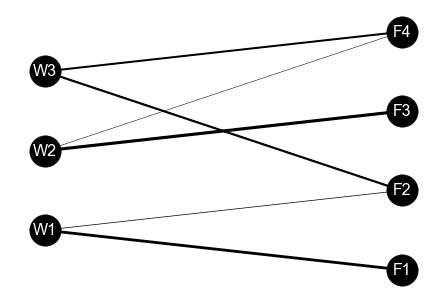

In [71]:
# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定とエッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i == j):
            # 辺の追加
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # エッジの重みの追加
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size

                edge_weights.append(weight)

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])

# 描画
nx.draw(
    G, pos, with_labels=True,
    font_size=16, font_color="w",
    node_size=1000, node_color="k",
    width=edge_weights
)

# 表示
plt.show()

In [72]:
print(G.edges, len(G.edges))
print(edge_weights, len(edge_weights))

[('W1', 'W2'), ('W1', 'W3'), ('W1', 'F1'), ('W1', 'F2'), ('W1', 'F3'), ('W1', 'F4'), ('W2', 'W3'), ('W2', 'F1'), ('W2', 'F2'), ('W2', 'F3'), ('W2', 'F4'), ('W3', 'F1'), ('W3', 'F2'), ('W3', 'F3'), ('W3', 'F4'), ('F1', 'F2'), ('F1', 'F3'), ('F1', 'F4'), ('F2', 'F3'), ('F2', 'F4'), ('F3', 'F4')] 21
[0, 0, 2.8000000000000003, 0.7000000000000001, 0, 0, 0, 0, 0, 3.1, 0.5, 0, 2.2, 0, 2.0, 0, 0, 0, 0, 0, 0] 21


### Knock63: 最適輸送ルートが制約条件内に収まっているか確認する